In [1]:
# Imports all packages necessary or useful

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Reads our time series data csv file

df = pd.read_csv(r"C:\Users\caleb\OneDrive\Desktop\WGU\D213 - Advanced Data Analytics\Medical Data\medical_time_series .csv")
df

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


In [3]:
# Quickly views our first 5 values

pd.set_option("display.max_columns", 0)
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [4]:
# Converts our 'Day' variable into date and time format
# For this project, 1/1/2022 is arbitrarily chosen is the start date

start_date = datetime(2022, 1, 1)
df['Date'] = start_date + pd.to_timedelta(df['Day'] - 1, unit='D')
df.set_index('Date', inplace = True)
df = df.drop('Day', axis = 1)
df

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,-0.292356
2022-01-03,-0.327772
2022-01-04,-0.339987
2022-01-05,-0.124888
...,...
2023-12-28,15.722056
2023-12-29,15.865822
2023-12-30,15.708988


In [5]:
# Checks for null values in our data set
# No null values are detected

df.isnull().sum()

Revenue    0
dtype: int64

In [6]:
# Drops any null values in our data set
# We appreciate 731 rows and 2 columns, consistent with our original data set

df = df.dropna()
df

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,-0.292356
2022-01-03,-0.327772
2022-01-04,-0.339987
2022-01-05,-0.124888
...,...
2023-12-28,15.722056
2023-12-29,15.865822
2023-12-30,15.708988


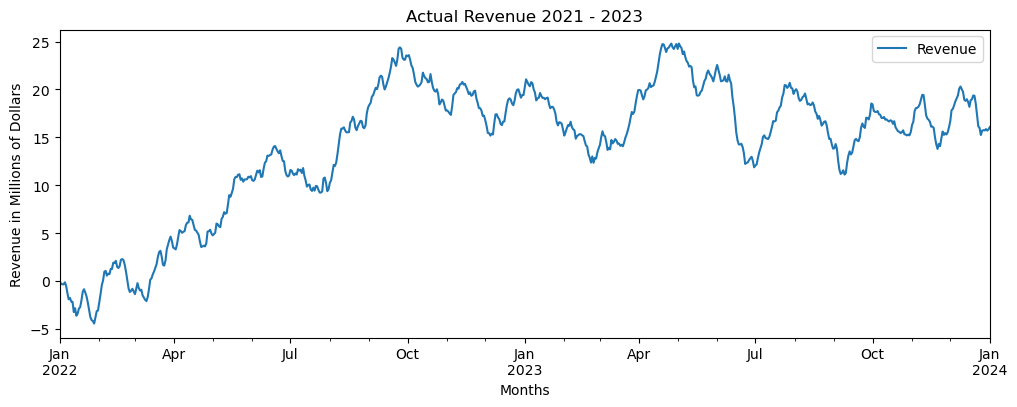

In [7]:
# Plots our revenue (millions) over time (days)

df['Revenue'].plot(figsize = (12, 4), label = 'Revenue')
plt.title('Actual Revenue 2021 - 2023')
plt.xlabel('Months')
plt.ylabel('Revenue in Millions of Dollars')
plt.legend()
plt.show()

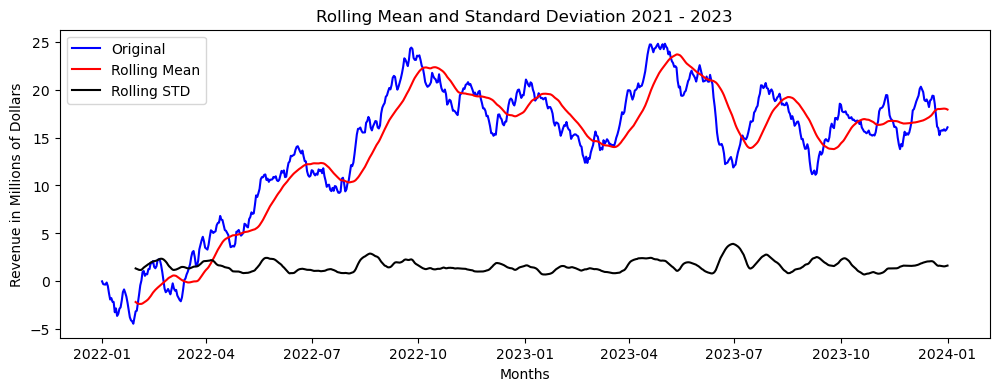

In [8]:
# Checks to see if our data is stationary
# Lags our data 30 days before establishing a rolling mean and rolling standard deviation

rolmean = df['Revenue'].rolling(window=30).mean()
rolstd = df['Revenue'].rolling(window=30).std()

plt.figure(figsize=(12, 4))
plt.plot(df['Revenue'], color = 'blue', label = 'Original')
plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
plt.plot(rolstd, color = 'black', label = 'Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation 2021 - 2023')
plt.xlabel('Months')
plt.ylabel('Revenue in Millions of Dollars')
plt.show(block = False)

In [9]:
# Runs an Augmented Dickey-Fuller Test on our data
# We appreciate a P-value significant greater than 0.05; indicates data is NOT stationary
# We appreciate all critical values are greater than our ADF value

df_adf = adfuller(df['Revenue'], autolag='AIC')
df_output = pd.Series(df_adf[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'No. Observations'])
for key,value in df_adf[4].items():
    df_output['Critical Value (%s) '%key] = value
df_output

Test Statistic            -2.218319
p-value                    0.199664
# Lags Used                1.000000
No. Observations         729.000000
Critical Value (1%)       -3.439352
Critical Value (5%)       -2.865513
Critical Value (10%)      -2.568886
dtype: float64

In [10]:
# Runs an Augmented Dickey-Fuller Test re-written as a function
# We appreciate a P-value significant greater than 0.05; indicates data is NOT stationary
# We appreciate all critical values are greater than our ADF value

def ad_test(df):
    dftest = adfuller(df, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-value: ', dftest[1])
    print('3. Number of Lags: ', dftest[2])
    print('4. Number of Observations Used for ADF Regression and Critical Values Calculation: ', dftest[3])
    print('5. Critical Values: ', dftest[4])
    for key, val in dftest[4].items():
          print('\t', key, ": ", val)
            
ad_test(df['Revenue'])

1. ADF:  -2.2183190476089436
2. P-value:  0.199664006150644
3. Number of Lags:  1
4. Number of Observations Used for ADF Regression and Critical Values Calculation:  729
5. Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


In [11]:
# Drops the first value in our data set try to make our data stationary

df2 = df.diff().dropna()
df2

,Revenue
Date,
2022-01-02,-0.292356
2022-01-03,-0.035416
2022-01-04,-0.012215
2022-01-05,0.215100
2022-01-06,-0.366702
...,...
2023-12-28,-0.032693
2023-12-29,0.143766
2023-12-30,-0.156834


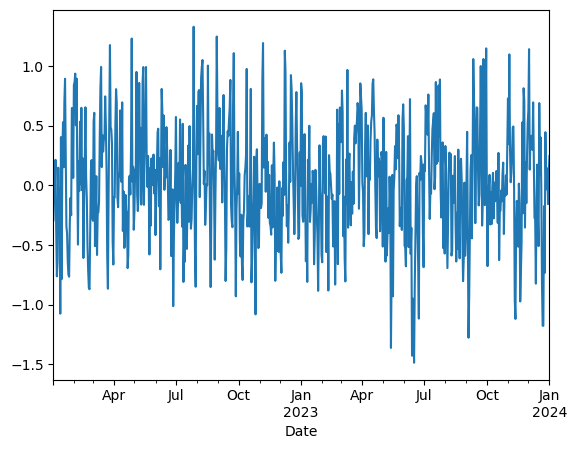

In [12]:
# Checks our differenced data visually for stationarity

df2['Revenue'].plot()
plt.show()

In [13]:
# Re-runs our ADF to check for stationarity
# We appreciate a P-value lower than 0.05; indicates data IS stationary

df_adf2 = adfuller(df2['Revenue'], autolag='AIC')
df_output2 = pd.Series(df_adf2[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'No. Observations'])
for key,value in df_adf2[4].items():
    df_output2['Critical Value (%s) '%key] = value
df_output2

Test Statistic          -1.737477e+01
p-value                  5.113207e-30
# Lags Used              0.000000e+00
No. Observations         7.290000e+02
Critical Value (1%)     -3.439352e+00
Critical Value (5%)     -2.865513e+00
Critical Value (10%)    -2.568886e+00
dtype: float64

In [14]:
# Creates train and test data for ARIMA using the last 30 days of our original data
# Splits our data 80/20; 'train' is split into 584 values, 'test' is split into 146 values

print(df2.shape)
train, test = train_test_split(df2, train_size = 0.8, test_size = 0.2, shuffle = False, random_state = 77)
print(train.shape, test.shape)

(730, 1)
(584, 1) (146, 1)


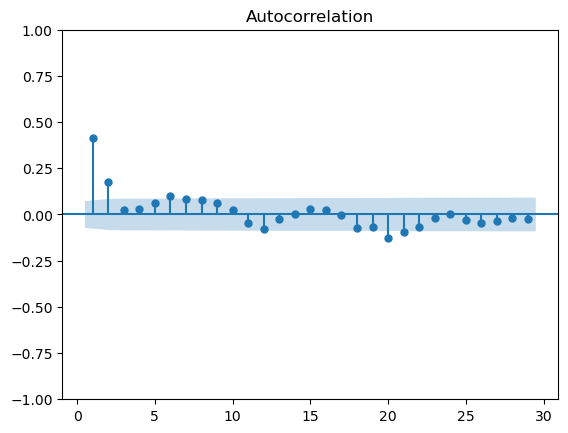

In [15]:
# Plots our ACF

plot_acf(df2, zero = False)
plt.show()

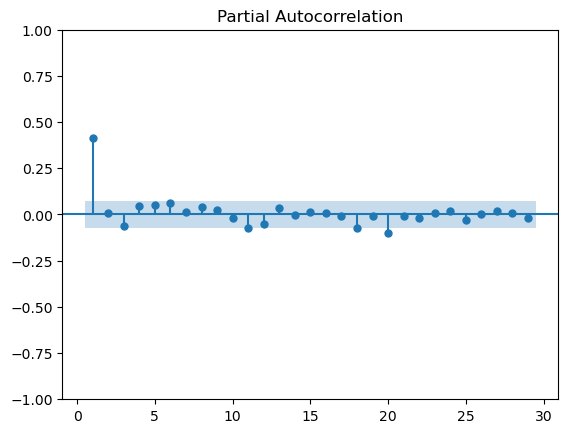

In [16]:
# Plots our PACF

plot_pacf(df2, zero = False)
plt.show()

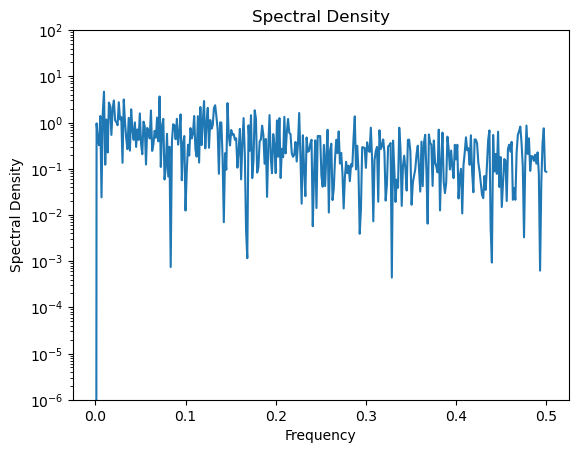

In [17]:
# Creates a visual of the spectral density for our stationary differenced data

f, Pxx_den = signal.periodogram(df2['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

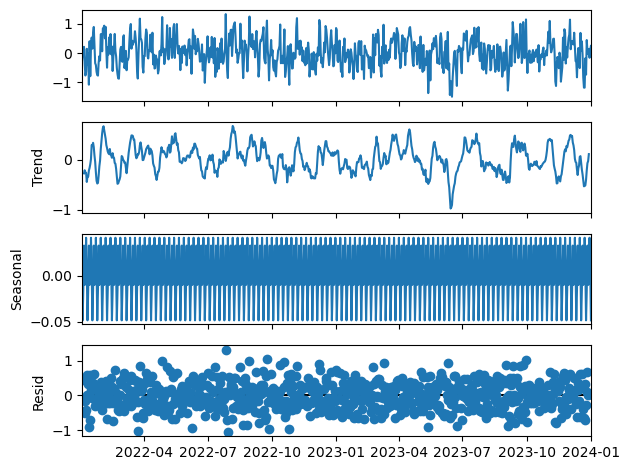

In [18]:
# Visualizes our decomposition metrics

result = seasonal_decompose(df2, model = 'additive')
result.plot()
plt.show()

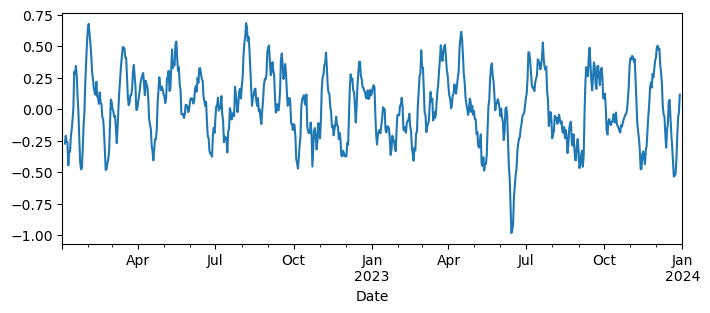

In [19]:
# Visualizes trend

plt.figure(figsize = (8, 3))
result.trend.plot()
plt.show()

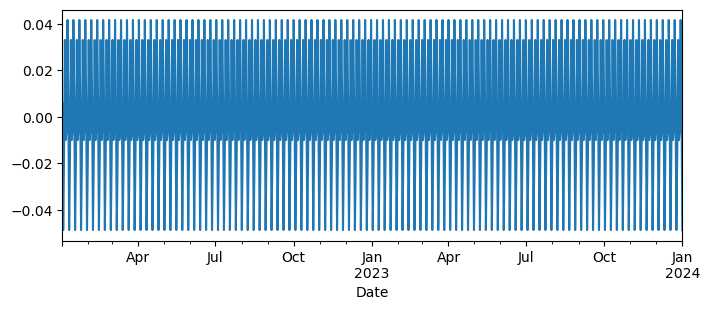

In [20]:
# Visualizes seasonality (in this case, lack of seasonality)

plt.figure(figsize = (8, 3))
result.seasonal.plot()
plt.show()

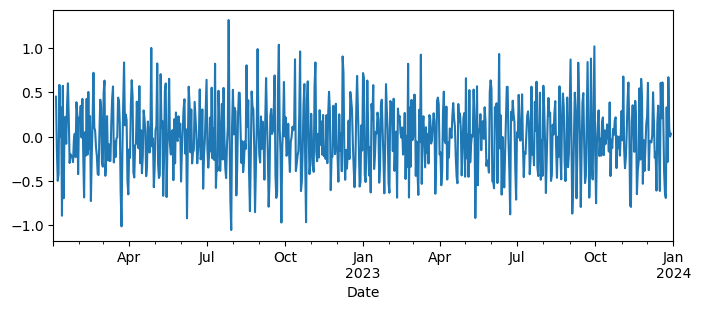

In [21]:
# Visualizes relatively constant variance of residuals

plt.figure(figsize = (8, 3))
result.resid.plot()
plt.show()

In [22]:
# Attempts to identify the best model using auto_arima
# We can run and compare 3 ARIMA models using different p, d, and q scores and select the model with the lowest AIC score

auto_arima(df2) 

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
# Creates our first ARIMA model; our first model will be based on results from our auto_arima library

model1 = ARIMA(train['Revenue'], order=(1,0,0), freq = 'D')
model1 = model1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Wed, 08 May 2024   AIC                            706.698
Time:                        22:12:20   BIC                            719.808
Sample:                    01-02-2022   HQIC                           711.808
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.000       0.170       0.218
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.75   Prob(JB):                         0.41
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Creates our second ARIMA model

model2 = ARIMA(train['Revenue'], order=(1,0,1), freq = 'D')
model2 = model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -350.132
Date:                Wed, 08 May 2024   AIC                            708.264
Time:                        22:12:20   BIC                            725.743
Sample:                    01-02-2022   HQIC                           715.076
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.032      1.029      0.303      -0.030       0.095
ar.L1          0.4542      0.098      4.639      0.000       0.262       0.646
ma.L1         -0.0554      0.109     -0.510      0.610      -0.268       0.157
sigma2         0.1941      0.012     15.706      0.000       0.170       0.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.96   Prob(JB):                         0.38
Heteroskedasticity (H):               1.04   Skew:                            -0.04
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Creates our third ARIMA model

model3 = ARIMA(train['Revenue'], order=(0,0,1), freq = 'D')
model3 = model3.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -361.723
Date:                Wed, 08 May 2024   AIC                            729.446
Time:                        22:12:21   BIC                            742.556
Sample:                    01-02-2022   HQIC                           734.556
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0329      0.025      1.328      0.184      -0.016       0.081
ma.L1          0.3274      0.038      8.561      0.000       0.252       0.402
sigma2         0.2020      0.012     16.288      0.000       0.178       0.226
===================================================================================
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.08   Prob(JB):                         0.57
Heteroskedasticity (H):               1.06   Skew:                            -0.06
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

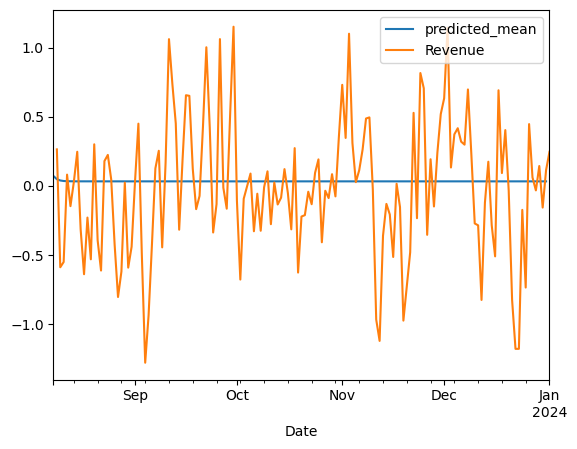

<Figure size 900x600 with 0 Axes>

In [26]:
# Creates our prediction based on model 1, as this model has the lowest AIC score

start = len(train)
end = len(train)+len(test)-1

pred = model1.predict(start = start, end = end)
pred.index = df.index[start:end+1]
pred.plot(legend = True)
test['Revenue'].plot(legend = True)
plt.figure(figsize=(9, 6))
plt.show()

In [27]:
# Predicts a mean 0.032791 increase in revenue per day

print(pred)

Date
2023-08-08    0.071071
2023-08-09    0.048405
2023-08-10    0.039159
2023-08-11    0.035388
2023-08-12    0.033850
                ...   
2023-12-27    0.032791
2023-12-28    0.032791
2023-12-29    0.032791
2023-12-30    0.032791
2023-12-31    0.032791
Name: predicted_mean, Length: 146, dtype: float64


In [28]:
# Displays the predicted mean 'Revenue for' our test data

test['Revenue'].mean()

-0.02221441438356165

In [29]:
# Calcutes the residual mean squared error for 'Revenue' in our test data

rmse = sqrt(mean_squared_error(pred, test['Revenue']))
rmse

0.48872356071083994

In [30]:
# Calculate mean squared error for our prediction model

mean_squared_error(test['Revenue'], pred)

0.23885071879388206

In [31]:
# Summarizes our best model

final_model = ARIMA(train['Revenue'], order=(1,0,0), freq = 'D')
final_model = final_model.fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Wed, 08 May 2024   AIC                            706.698
Time:                        22:12:21   BIC                            719.808
Sample:                    01-02-2022   HQIC                           711.808
                         - 08-08-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.000       0.170       0.218
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.75   Prob(JB):                         0.41
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

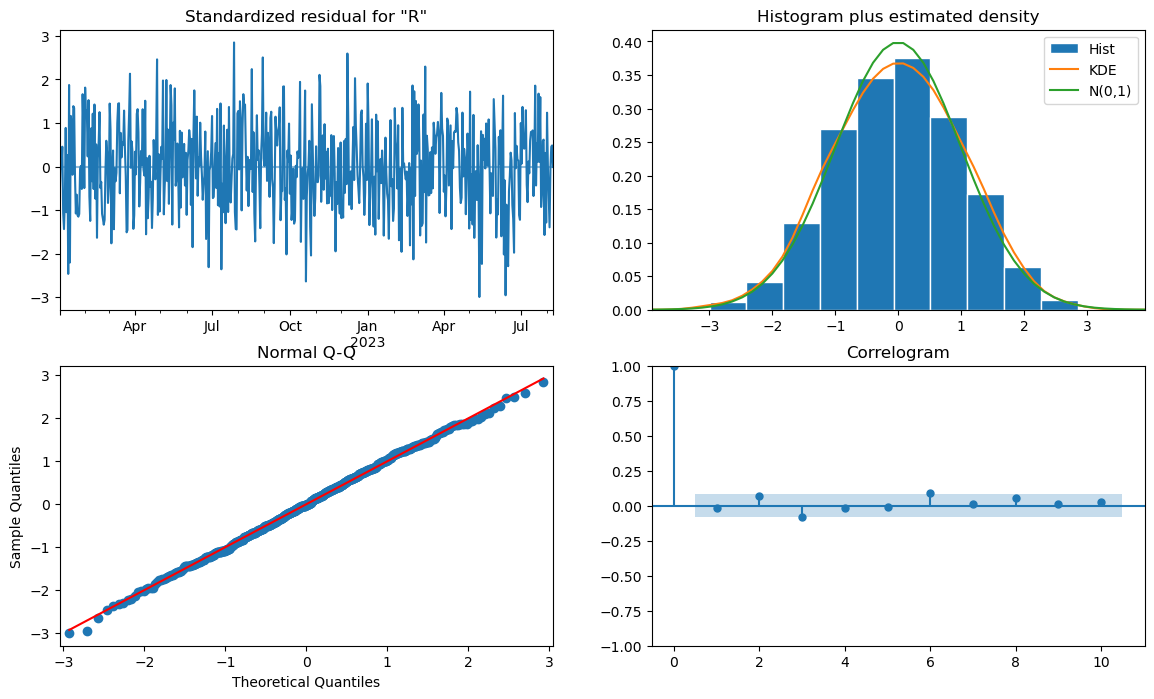

In [32]:
# Runs a diagnostic of our model to detect any unusual characteristics 

final_model.plot_diagnostics(figsize=(14, 8))
plt.show()

In [33]:
# Creates a data fame that includes our untransformed test data

train_test_scale = pd.concat([train, test])
test_scale = train_test_scale.cumsum()
test_scale = test_scale.iloc[-146:]
test_scale

,Revenue
Date,
2023-08-09,19.576725
2023-08-10,18.988035
2023-08-11,18.437608
2023-08-12,18.519085
2023-08-13,18.372498
...,...
2023-12-28,15.722056
2023-12-29,15.865822
2023-12-30,15.708988


In [34]:
# Converts our 'pred' series to a data frame
# Note that this value starts at '2023-08-08'

pred_df = pred.to_frame()
pred_df = pred_df.rename(columns={'predicted_mean' : 'Revenue'})
pred_df

,Revenue
Date,
2023-08-08,0.071071
2023-08-09,0.048405
2023-08-10,0.039159
2023-08-11,0.035388
2023-08-12,0.033850
...,...
2023-12-27,0.032791
2023-12-28,0.032791
2023-12-29,0.032791


In [35]:
# Creates a data frame that includes untransformed prediction data

pred_sum = pd.concat([train, pred_df])
pred_sum = pred_sum.cumsum()
pred_sum = pred_sum.loc['2023-08-09':]
pred_sum

,Revenue
Date,
2023-08-09,19.432210
2023-08-10,19.471369
2023-08-11,19.506758
2023-08-12,19.540608
2023-08-13,19.573831
...,...
2023-12-27,24.033683
2023-12-28,24.066474
2023-12-29,24.099265


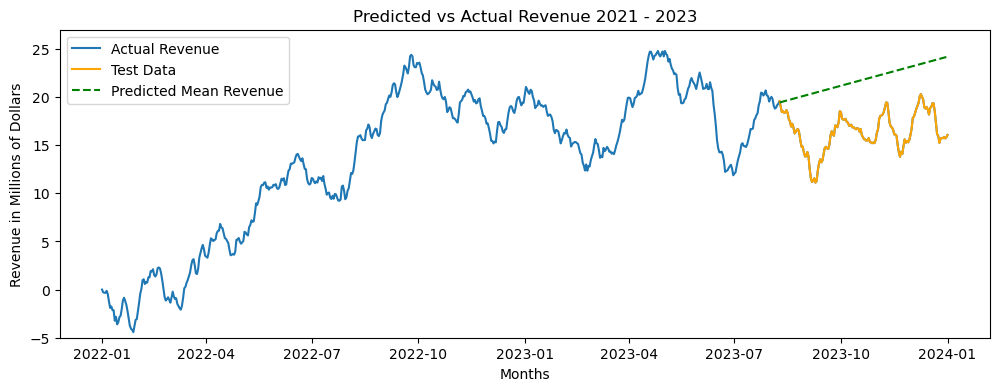

In [36]:
# Plots our mean prediction versus actual revenue
# According to our model, LESS revenue on average was collected than predicted

plt.figure(figsize = (12, 4))
plt.title('Predicted vs Actual Revenue 2021 - 2023')
plt.plot(df, label = 'Actual Revenue')
plt.plot(test_scale, color = 'orange', label = 'Test Data')
plt.plot(pred_sum, color = 'green', linestyle = 'dashed', label = 'Predicted Mean Revenue')
plt.ylim(-5, 27)
plt.xlabel('Months')
plt.ylabel('Revenue in Millions of Dollars')
plt.legend(loc = 'upper left')
plt.show()

In [37]:
# Creates a 90 day forecasted mean and confidence interval for our data
# We can be 95% confident that each successive value will either decrease from the mean by 0.913421 or increase from the mean by 0.979002

df_forecast = model1.get_forecast()
mean_forecast = df_forecast.predicted_mean
mod_forecast = model1.get_prediction(start = 730, end = 820, dynamic = False)
confidence_intervals = mod_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']
confidence_intervals

,lower Revenue,upper Revenue
2024-01-02,-0.913421,0.979002
2024-01-03,-0.913421,0.979002
2024-01-04,-0.913421,0.979002
2024-01-05,-0.913421,0.979002
2024-01-06,-0.913421,0.979002
...,...,...
2024-03-28,-0.913421,0.979002
2024-03-29,-0.913421,0.979002
2024-03-30,-0.913421,0.979002
2024-03-31,-0.913421,0.979002


In [38]:
# Creates a 90 day forecast model for our data

fmod = ARIMA(df['Revenue'], order=(1,0,0), freq = 'D')
fmod_result = fmod.fit()
forecast = fmod_result.predict(start = 730, end = 820, dynamic = False).rename('Forecast')

In [39]:
# Identifies a starting point for our confidence interval

forecast_start = forecast.iloc[1]
forecast_start

16.06201367685531

In [40]:
# Creates a data frame for our new starting value

ci_add = {'lower Revenue': [16.06201367685531], 'upper Revenue': [16.06201367685531]}
new_index = ['2024-01-01']
ci_start = pd.DataFrame(ci_add, index=new_index)
ci_start

,lower Revenue,upper Revenue
2024-01-01,16.062014,16.062014


In [41]:
# Creates a combined data frame to build a visualization for our confidence interval

ci_sum = pd.concat([ci_start, confidence_intervals])
ci_sum = ci_sum.cumsum()
ci_sum

,lower Revenue,upper Revenue
2024-01-01,16.062014,16.062014
2024-01-02 00:00:00,15.148593,17.041016
2024-01-03 00:00:00,14.235172,18.020018
2024-01-04 00:00:00,13.321752,18.999021
2024-01-05 00:00:00,12.408331,19.978023
...,...,...
2024-03-28 00:00:00,-63.405581,101.235215
2024-03-29 00:00:00,-64.319002,102.214218
2024-03-30 00:00:00,-65.232423,103.193220
2024-03-31 00:00:00,-66.145843,104.172222


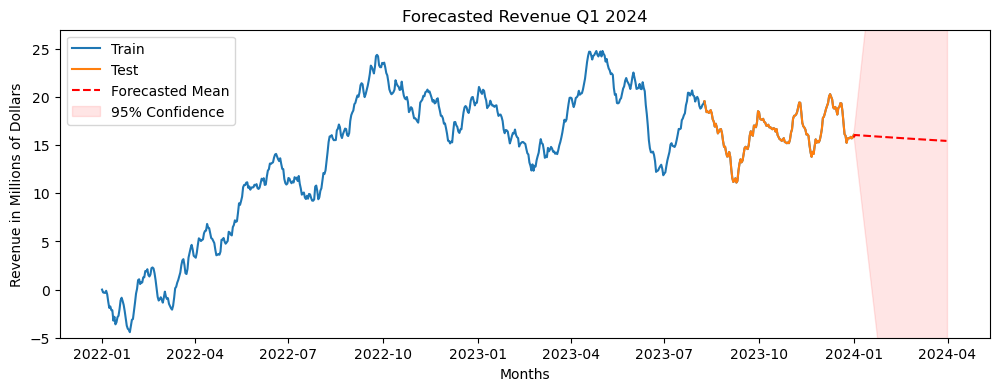

In [42]:
# Visualizes our prediction and 90 day forecast with a confidence interval
# Trains the model on the full dataset and forecasts values for the next 3 months, then plots results

plt.figure(figsize = (12, 4))
plt.title('Forecasted Revenue Q1 2024')
plt.plot(df['Revenue'], label = 'Train')
plt.plot(test_scale, label = 'Test')
plt.plot(forecast, color = 'red', linestyle = 'dashed', label = 'Forecasted Mean')
plt.fill_between(ci_sum.index, ci_sum['lower Revenue'], ci_sum['upper Revenue'], color = 'red', alpha = 0.1, label = '95% Confidence')
plt.ylim(-5, 27)
plt.xlabel('Months')
plt.ylabel('Revenue in Millions of Dollars')
plt.legend(loc = 'upper left')
plt.show()